# D(S)tream of Anomailies

## Introduction

#### This project is about building one or more anomaly detection models to detect anomalies using other columns as features

* The data was obtained from:
https://www.kaggle.com/boltzmannbrain/nab

* The data is aboutambient_temperature_system_failure.csv: The ambient temperature in an office

### Importing Libraries 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import sys 
import matplotlib 

%matplotlib inline
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
from sklearn.svm import OneClassSVM

### Import the data

In [2]:
data = pd.read_csv("Data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv") 
data.head(10)

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836
5,2013-12-02 21:40:00,78.710418
6,2013-12-02 21:45:00,80.269784
7,2013-12-02 21:50:00,80.272828
8,2013-12-02 21:55:00,80.353425
9,2013-12-02 22:00:00,79.486523


In [3]:
data.describe()

,value
count,22695.000000
mean,85.926498
std,13.746912
min,2.084721
25%,83.080078
50%,89.408246
75%,94.016252
max,108.510543


* Now we are going to try to find the date range of the data

In [4]:
data['timestamp'].min(), data['timestamp'].max()

('2013-12-02 21:15:00', '2014-02-19 15:25:00')

* We can see that the data is between december 2 2013 and february 19 2014.

* Now we are going to convert "Date" to date format

In [5]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

### Visualizing Temperature with time

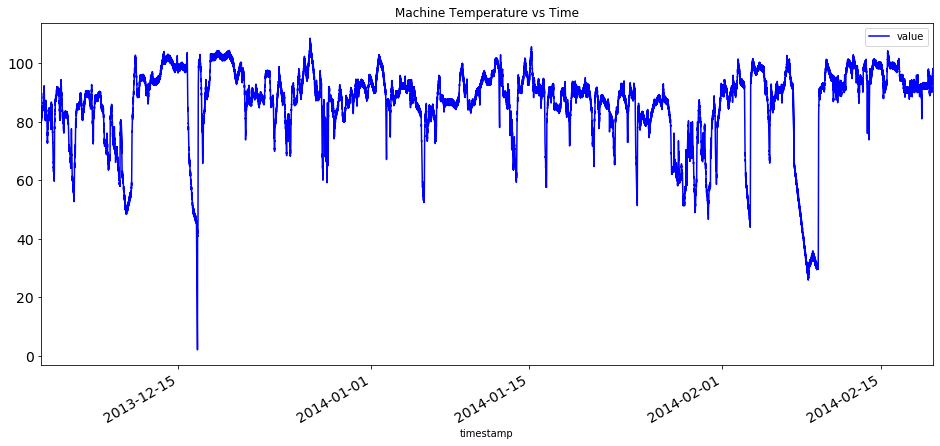

In [6]:
data.plot(x='timestamp', y='value',figsize=(16,7), title= 'Machine Temperature vs Time',color='Blue', fontsize=14)

### Feature Engineering

* Since our timestamp column contains extra information we are going to try to utilize this extra information by using it to create new columns

* The columns we are going to create are Hours, Daylight, DayOfTheWeek and WeekDay

In [7]:
#Create additional Columns 
# Hours - Denote hour of day
# DayLight - Denote Day and Night
# Day of The Week - MTWRFSS
# WeekDay - To denote Weekday or Weekend
data['Hours'] = data['timestamp'].dt.hour
data['Daylight'] = ((data['Hours'] >= 7) & (data['Hours'] <= 22)).astype(int)

data['DayOfTheWeek'] = data['timestamp'].dt.dayofweek
data['WeekDay'] = (data['DayOfTheWeek'] < 5).astype(int)
data.head()

,timestamp,value,Hours,Daylight,DayOfTheWeek,WeekDay
0,2013-12-02 21:15:00,73.967322,21,1,0,1
1,2013-12-02 21:20:00,74.935882,21,1,0,1
2,2013-12-02 21:25:00,76.124162,21,1,0,1
3,2013-12-02 21:30:00,78.140707,21,1,0,1
4,2013-12-02 21:35:00,79.329836,21,1,0,1


In [8]:

## Create Categories
###    WeekEndNight - Denotes weekend night
###    WeekEndDay - Denotes weekend day
###    WeekDayNight - Denotes weekday night
###    WeekDayDay - Denotes weekday day

data['Categories'] = data['WeekDay']*2 + data['Daylight']

a = data.loc[data['Categories'] == 0, 'value']
b = data.loc[data['Categories'] == 1, 'value']
c = data.loc[data['Categories'] == 2, 'value']
d = data.loc[data['Categories'] == 3, 'value']

data.head(10)

,timestamp,value,Hours,Daylight,DayOfTheWeek,WeekDay,Categories
0,2013-12-02 21:15:00,73.967322,21,1,0,1,3
1,2013-12-02 21:20:00,74.935882,21,1,0,1,3
2,2013-12-02 21:25:00,76.124162,21,1,0,1,3
3,2013-12-02 21:30:00,78.140707,21,1,0,1,3
4,2013-12-02 21:35:00,79.329836,21,1,0,1,3
5,2013-12-02 21:40:00,78.710418,21,1,0,1,3
6,2013-12-02 21:45:00,80.269784,21,1,0,1,3
7,2013-12-02 21:50:00,80.272828,21,1,0,1,3
8,2013-12-02 21:55:00,80.353425,21,1,0,1,3
9,2013-12-02 22:00:00,79.486523,22,1,0,1,3


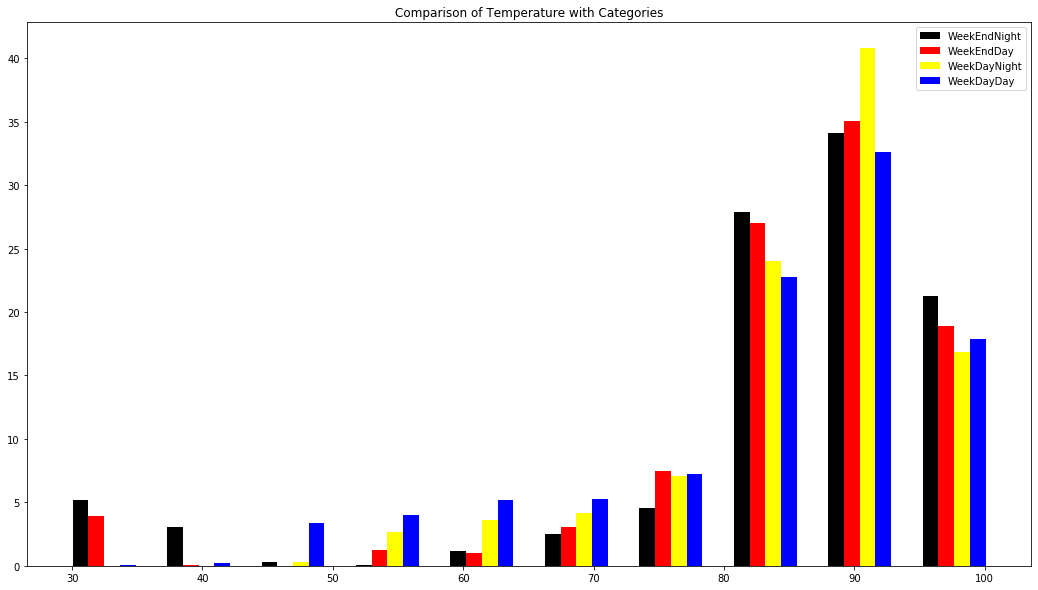

In [9]:
##Ploting the categories timestamp
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='black', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='red', label ='WeekEndDay')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='yellow', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='blue', label ='WeekDayDay')


fig.set_size_inches(18,10)
plt.title("Comparison of Temperature with Categories")
plt.legend()
plt.show()

## Anomaly Detection 

### Isolation Forest

In [10]:
isolationforest_data = data[['value', 'Hours', 'Daylight', 'DayOfTheWeek', 'WeekDay']]

min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(isolationforest_data)
isolationforest_data = pd.DataFrame(np_scaled)

model =  IsolationForest(contamination = 0.05)
model.fit(isolationforest_data)

anomalyBasic = pd.Series(model.predict(isolationforest_data))
anomalyBasic = anomalyBasic.map( {1: 0, -1: 1} )
print(anomalyBasic.value_counts())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


0    21560
1     1135
dtype: int64


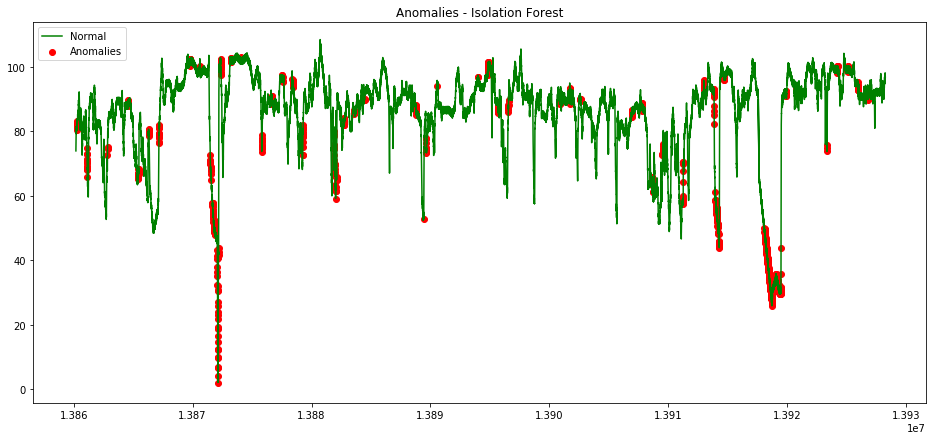

In [24]:
#Visualisation of anomaly
fig, ax = plt.subplots()

data['Time'] = (data['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

a = data.loc[anomalyBasic == 1, ['Time', 'value']] #anomaly

fig.set_size_inches(16,7)
ax.plot(data['Time'], data['value'], color='green',label='Normal')
ax.scatter(a['Time'],a['value'], color='red',label='Anomalies')
plt.title("Anomalies - Isolation Forest")
plt.legend()
plt.show()

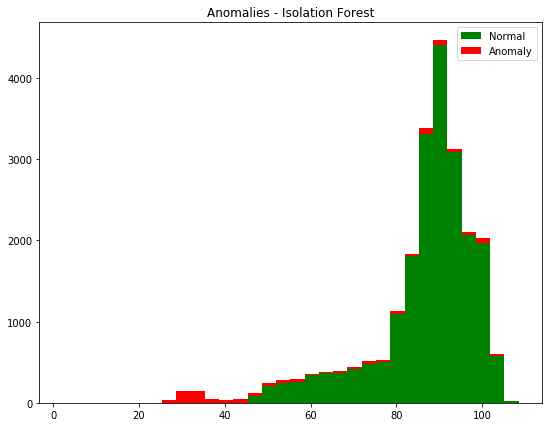

In [25]:
#Visualisation of anomaly with temperature repartition (viz 2)
a = data.loc[anomalyBasic == 0, 'value']
b = data.loc[anomalyBasic == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['green', 'red'], label = ['Normal', 'Anomaly'])
fig.set_size_inches(9,7)
plt.title("Anomalies - Isolation Forest")
plt.legend()
plt.show()

### OneClass SVM

In [13]:
svm_data = data[['value', 'Hours', 'Daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(svm_data)

model =  OneClassSVM(nu=0.95 * 0.05)
svm_data = pd.DataFrame(np_scaled)
model.fit(svm_data)

data['anomalySVM'] = pd.Series(model.predict(svm_data))
data['anomalySVM'] = data['anomalySVM'].map( {1: 0, -1: 1} )
print(data['anomalySVM'].value_counts())

0    21617
1     1078
Name: anomalySVM, dtype: int64


In [14]:
data.head()

,timestamp,value,Hours,Daylight,DayOfTheWeek,WeekDay,Categories,Time,anomalySVM
0,2013-12-02 21:15:00,73.967322,21,1,0,1,3,13860189,0
1,2013-12-02 21:20:00,74.935882,21,1,0,1,3,13860192,0
2,2013-12-02 21:25:00,76.124162,21,1,0,1,3,13860195,0
3,2013-12-02 21:30:00,78.140707,21,1,0,1,3,13860198,0
4,2013-12-02 21:35:00,79.329836,21,1,0,1,3,13860201,0


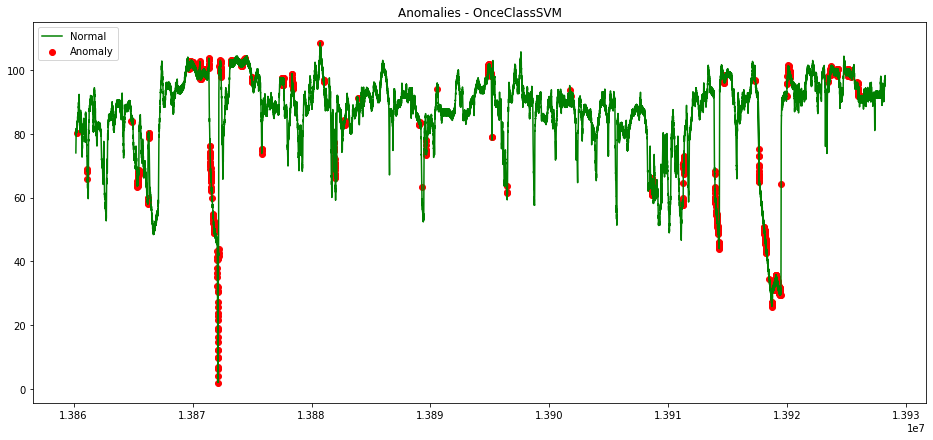

In [23]:
#Visualisation
fig, ax = plt.subplots()

a = data.loc[data['anomalySVM'] == 1, ['Time', 'value']] #anomaly

fig.set_size_inches(16,7)

ax.plot(data['Time'], data['value'], color='green',label='Normal')
ax.scatter(a['Time'],a['value'], color='red',label='Anomaly')

plt.title("Anomalies - OnceClassSVM")
plt.legend()
plt.show()

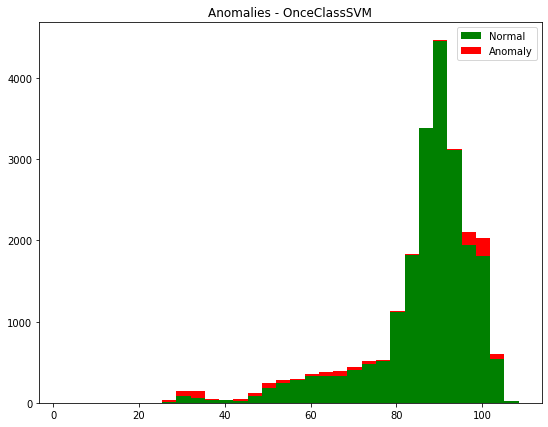

In [26]:
#Visualisation of anomaly with temperature repartition (viz 2)
a = data.loc[data['anomalySVM'] == 0, 'value']
b = data.loc[data['anomalySVM'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['green', 'red'], label=['Normal', 'Anomaly'])
plt.title("Anomalies - OnceClassSVM")
fig.set_size_inches(9,7)
plt.legend()
plt.show()


## Conclusion:
I implemented two anomaly detection models: Isolation Forest and One Class SVM.

* Summary of results (anomalies detected) from the two models:

    * Isolation Forest: 1133 anomalies detected out of 22695 records
    * One ClassSVM: 1078 anomalies detected out of 22695 records